In [1]:
# ================================================================
# Imports
# ================================================================
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import random

In [2]:
# ================================================================
# Dataset Definition for H5 frames
# ================================================================
BASE_DIR = "./data/AU"
IMAGE_DIR = os.path.join(BASE_DIR, "image")
META_DIR = os.path.join(BASE_DIR, "metadata")

class TyphoonSequenceDataset(Dataset):
    """
    Creates 10-frame sequences of typhoon .h5 images with constant grade.
    Each sample: (x, y)
        x: Tensor [seq_len, 1, H, W]
        y: intensity grade (0–5)
    """

    def __init__(self, base_dir, seq_len=10, transform=None):
        self.base_dir = base_dir
        self.seq_len = seq_len
        self.transform = transform
        self.image_dir = os.path.join(base_dir, "image")
        self.meta_dir = os.path.join(base_dir, "metadata")
        self.samples = self._prepare_sequences()

    def _list_h5_files(self, typhoon_id):
        dir_path = os.path.join(self.image_dir, typhoon_id)
        files = sorted([
            os.path.join(dir_path, f)
            for f in os.listdir(dir_path)
            if f.lower().endswith(".h5")
        ])
        return files

    def _load_metadata(self, typhoon_id):
        path = os.path.join(self.meta_dir, f"{typhoon_id}.csv")
        if not os.path.exists(path):
            return None
        return pd.read_csv(path)

    def _prepare_sequences(self):
        typhoon_ids = sorted([
            d for d in os.listdir(self.image_dir)
            if os.path.isdir(os.path.join(self.image_dir, d))
        ])

        samples = []
        for typhoon_id in tqdm(typhoon_ids, desc="Building sequences"):
            meta = self._load_metadata(typhoon_id)
            h5_files = self._list_h5_files(typhoon_id)
            if meta is None or "grade" not in meta.columns:
                continue

            grades = meta["grade"].fillna(-1).astype(int).values
            n_frames = min(len(grades), len(h5_files))
            grades = grades[:n_frames]
            h5_files = h5_files[:n_frames]

            start = 0
            while start < n_frames:
                current_grade = grades[start]
                end = start
                while end < n_frames and grades[end] == current_grade:
                    end += 1
                segment_len = end - start
                if current_grade >= 0 and segment_len >= self.seq_len:
                    for i in range(segment_len - self.seq_len + 1):
                        frame_paths = h5_files[start + i:start + i + self.seq_len]
                        samples.append((typhoon_id, frame_paths, current_grade))
                start = end
        return samples

    def __len__(self):
        return len(self.samples)

    def _load_h5_image(self, path):
        with h5py.File(path, "r") as f:
            arr = np.array(f["Infrared"])
        arr = arr.astype(np.float32)
        arr = (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)
        import PIL.Image
        img = PIL.Image.fromarray((arr * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)
        else:
            img = transforms.ToTensor()(img)
        return img

    def __getitem__(self, idx):
        _, frame_paths, grade = self.samples[idx]
        imgs = [self._load_h5_image(p) for p in frame_paths]
        x = torch.stack(imgs)  # [seq_len, 1, H, W]
        y = torch.tensor(grade, dtype=torch.long)
        return x, y


# ================================================================
# Create Dataset + Dataloaders
# ================================================================
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

dataset = TyphoonSequenceDataset(BASE_DIR, seq_len=10, transform=transform)
print(f"\nTotal 10-frame constant-grade sequences found: {len(dataset)}")

train_size = int(0.9 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False)



Building sequences: 100%|████████████████████| 480/480 [00:01<00:00, 407.47it/s]


Total 10-frame constant-grade sequences found: 50018


In [3]:
# import h5py

# path = "./data/AU/image/201303/2012122613-201303-MTS2-1.h5"

# with h5py.File(path, "r") as f:
#     print("Keys:", list(f.keys()))
#     for k in f.keys():
#         dset = f[k]
#         print(f"  {k}: shape={dset.shape}, dtype={dset.dtype}")

Keys: ['Infrared']
  Infrared: shape=(512, 512), dtype=float64


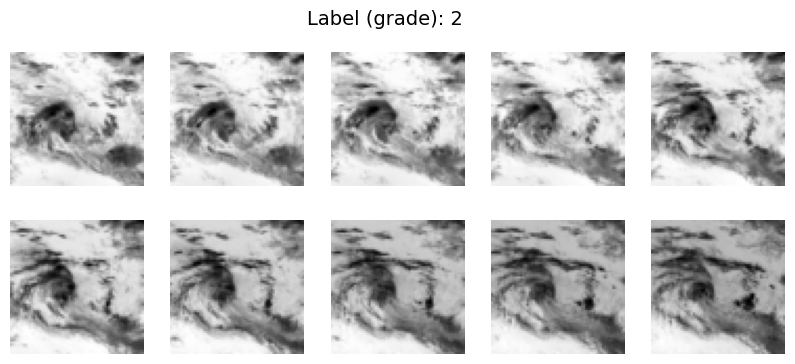

In [4]:
# ================================================================
# Visualize one random sequence
# ================================================================
x, y = random.choice(dataset)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x[i, 0].numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle(f"Label (grade): {y.item()}", fontsize=14)
plt.show()

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

# ================================================================
# ConvLSTM Cell & Classifier
# ================================================================
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_dim + hidden_dim, 4 * hidden_dim,
                              kernel_size, padding=self.padding, bias=bias)

    def forward(self, x, h_prev, c_prev):
        combined = torch.cat([x, h_prev], dim=1)
        conv_out = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_out, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c = f * c_prev + i * g
        h = o * torch.tanh(c)
        return h, c


class ConvLSTMClassifier(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_classes=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_dim, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.convlstm = ConvLSTMCell(32, hidden_dim, 3)
        self.fc = nn.Linear(hidden_dim * 16 * 16, num_classes)

    def forward(self, x_seq):
        batch_size, seq_len, _, _, _ = x_seq.shape
        h, c = (torch.zeros(batch_size, 64, 16, 16, device=x_seq.device),
                torch.zeros(batch_size, 64, 16, 16, device=x_seq.device))
        for t in range(seq_len):
            feat = self.encoder(x_seq[:, t])
            h, c = self.convlstm(feat, h, c)
        out = h.view(batch_size, -1)
        return self.fc(out)


# ================================================================
# Training Setup
# ================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvLSTMClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
val_interval = 200

train_losses, val_losses = [] , []


# ================================================================
# Validation Helper (single-line tqdm)
# ================================================================
@torch.no_grad()
def evaluate_model(model, loader, criterion, device, desc="Validation"):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, desc=desc, leave=False, ncols=100, position=0)

    for xb, yb in pbar:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        total_loss += loss.item()
        correct += (preds.argmax(dim=1) == yb).sum().item()
        total += yb.size(0)
        pbar.set_postfix_str(f"batch_loss={loss.item():.4f}")

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# ================================================================
# Training Loop (track avg loss between validation intervals)
# ================================================================
global_step = 0
running_loss = 0.0
steps_since_val = 0
train_interval_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_iter = tqdm(train_dl, desc=f"Epoch {epoch+1}/{epochs} [Train]", ncols=100)
    
    for xb, yb in train_iter:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_loss += loss.item()
        steps_since_val += 1
        global_step += 1

        train_iter.set_postfix_str(f"step={global_step}, loss={loss.item():.4f}")

        if global_step % val_interval == 0:
            avg_train_loss = running_loss / steps_since_val
            train_interval_losses.append(avg_train_loss)

            running_loss = 0.0
            steps_since_val = 0

            val_loss, val_acc = evaluate_model(model, val_dl, criterion, device,
                                               desc=f"Step {global_step} [Val]")
            val_losses.append(val_loss)
            tqdm.write(f"[Step {global_step}] Val — Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

            model.train()

    if steps_since_val > 0:
        avg_train_loss = running_loss / steps_since_val
        tqdm.write(f"Epoch {epoch+1} — Avg Train Loss (since last val): {avg_train_loss:.4f}")

tqdm.write("✅ Training complete!")

Epoch 1/1 [Train]:   4%|▌              | 200/5627 [04:53<80:18:58, 53.28s/it, step=200, loss=1.6113]

[Step 200] Val — Loss: 1.1335, Acc: 57.00%


Epoch 1/1 [Train]:   7%|█              | 400/5627 [09:44<77:48:38, 53.59s/it, step=400, loss=0.7834]

[Step 400] Val — Loss: 1.0723, Acc: 60.76%


Epoch 1/1 [Train]:  11%|█▌             | 600/5627 [14:36<74:57:10, 53.68s/it, step=600, loss=1.2426]

[Step 600] Val — Loss: 1.0473, Acc: 61.32%


Epoch 1/1 [Train]:  14%|██▏            | 800/5627 [19:29<71:48:24, 53.55s/it, step=800, loss=0.9390]

[Step 800] Val — Loss: 0.9919, Acc: 62.76%


Epoch 1/1 [Train]:  18%|██▎          | 1000/5627 [24:21<68:51:48, 53.58s/it, step=1000, loss=0.9707]

[Step 1000] Val — Loss: 1.0055, Acc: 62.36%


Epoch 1/1 [Train]:  21%|██▊          | 1200/5627 [29:13<65:57:56, 53.64s/it, step=1200, loss=1.3047]

[Step 1200] Val — Loss: 0.9920, Acc: 62.48%


Epoch 1/1 [Train]:  25%|███▏         | 1400/5627 [34:05<62:52:46, 53.55s/it, step=1400, loss=1.3501]

[Step 1400] Val — Loss: 0.9896, Acc: 62.68%


Epoch 1/1 [Train]:  28%|███▋         | 1600/5627 [38:57<60:13:25, 53.84s/it, step=1600, loss=0.7934]

[Step 1600] Val — Loss: 0.9877, Acc: 63.20%


Epoch 1/1 [Train]:  32%|████▏        | 1800/5627 [43:48<57:02:32, 53.66s/it, step=1800, loss=1.0438]

[Step 1800] Val — Loss: 0.9670, Acc: 63.72%


Epoch 1/1 [Train]:  36%|████▌        | 2000/5627 [48:42<54:22:36, 53.97s/it, step=2000, loss=0.7659]

[Step 2000] Val — Loss: 0.9475, Acc: 63.64%


Epoch 1/1 [Train]:  39%|█████        | 2200/5627 [53:35<51:28:36, 54.08s/it, step=2200, loss=0.6841]

[Step 2200] Val — Loss: 0.9568, Acc: 62.88%


Epoch 1/1 [Train]:  43%|█████▌       | 2400/5627 [58:28<48:22:38, 53.97s/it, step=2400, loss=1.1051]

[Step 2400] Val — Loss: 0.9719, Acc: 62.36%


Epoch 1/1 [Train]:  46%|█████      | 2600/5627 [1:03:22<45:38:05, 54.27s/it, step=2600, loss=0.6759]

[Step 2600] Val — Loss: 0.9433, Acc: 64.08%


Epoch 1/1 [Train]:  50%|█████▍     | 2800/5627 [1:08:16<42:33:05, 54.19s/it, step=2800, loss=1.3577]

[Step 2800] Val — Loss: 0.8920, Acc: 66.36%


Epoch 1/1 [Train]:  53%|█████▊     | 3000/5627 [1:13:11<39:31:12, 54.16s/it, step=3000, loss=1.4468]

[Step 3000] Val — Loss: 0.9022, Acc: 66.36%


Epoch 1/1 [Train]:  57%|██████▎    | 3200/5627 [1:18:03<36:14:52, 53.77s/it, step=3200, loss=0.8683]

[Step 3200] Val — Loss: 0.8851, Acc: 66.36%


Epoch 1/1 [Train]:  60%|██████▋    | 3400/5627 [1:22:57<33:15:00, 53.75s/it, step=3400, loss=0.9472]

[Step 3400] Val — Loss: 0.9332, Acc: 65.44%


Epoch 1/1 [Train]:  64%|███████    | 3600/5627 [1:27:50<30:20:55, 53.90s/it, step=3600, loss=1.2279]

[Step 3600] Val — Loss: 0.8721, Acc: 66.44%


Epoch 1/1 [Train]:  68%|███████▍   | 3800/5627 [1:32:45<27:35:14, 54.36s/it, step=3800, loss=0.5575]

[Step 3800] Val — Loss: 0.8291, Acc: 68.56%


Epoch 1/1 [Train]:  71%|███████▊   | 4000/5627 [1:37:41<24:32:44, 54.31s/it, step=4000, loss=1.3968]

[Step 4000] Val — Loss: 0.8313, Acc: 68.32%


Epoch 1/1 [Train]:  75%|████████▏  | 4200/5627 [1:42:38<21:40:41, 54.69s/it, step=4200, loss=0.6172]

[Step 4200] Val — Loss: 0.8028, Acc: 68.72%


Epoch 1/1 [Train]:  78%|████████▌  | 4400/5627 [1:47:33<18:32:29, 54.40s/it, step=4400, loss=1.6639]

[Step 4400] Val — Loss: 0.7794, Acc: 69.32%


Epoch 1/1 [Train]:  82%|████████▉  | 4600/5627 [1:52:29<15:30:59, 54.39s/it, step=4600, loss=0.6778]

[Step 4600] Val — Loss: 0.7576, Acc: 70.48%


Epoch 1/1 [Train]:  85%|█████████▍ | 4800/5627 [1:57:26<12:33:11, 54.65s/it, step=4800, loss=0.6724]

[Step 4800] Val — Loss: 0.7432, Acc: 71.84%


Epoch 1/1 [Train]:  89%|██████████▋ | 5000/5627 [2:02:20<9:26:16, 54.19s/it, step=5000, loss=0.8734]

[Step 5000] Val — Loss: 0.7464, Acc: 71.68%


Epoch 1/1 [Train]:  92%|███████████ | 5200/5627 [2:07:17<6:28:31, 54.59s/it, step=5200, loss=0.6927]

[Step 5200] Val — Loss: 0.7222, Acc: 72.76%


Epoch 1/1 [Train]:  96%|███████████▌| 5400/5627 [2:12:14<3:26:23, 54.55s/it, step=5400, loss=0.2682]

[Step 5400] Val — Loss: 0.7094, Acc: 72.52%


Epoch 1/1 [Train]: 100%|█████████████▉| 5600/5627 [2:17:07<24:24, 54.25s/it, step=5600, loss=0.3170]

[Step 5600] Val — Loss: 0.6936, Acc: 73.16%


Epoch 1/1 [Train]: 100%|██████████████| 5627/5627 [2:17:23<00:00,  1.47s/it, step=5627, loss=1.0800]

Epoch 1 — Avg Train Loss (since last val): 0.7314
✅ Training complete!


In [7]:
#print(train_losses)

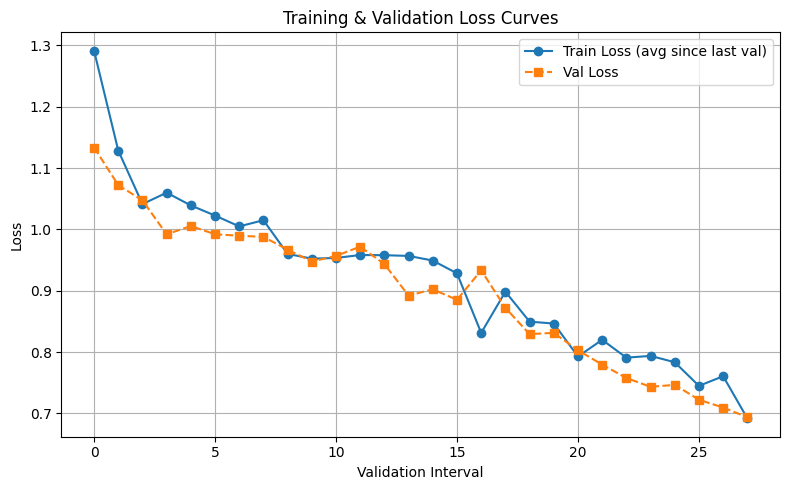

In [8]:
# ================================================================
# Plot Training & Validation Losses (interval-aligned)
# ================================================================
plt.figure(figsize=(8,5))
plt.plot(train_interval_losses, label="Train Loss (avg since last val)", marker='o')
plt.plot(val_losses, label="Val Loss", linestyle="--", marker='s')
plt.xlabel("Validation Interval")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# ================================================================
# Save Model Checkpoint
# ================================================================
MODEL_PATH = "convlstm_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'train_losses': train_losses,
    'val_losses': val_losses
}, MODEL_PATH)

print(f"✅ Model saved to {MODEL_PATH}")

✅ Model saved to convlstm_classifier.pth


# INFERENCE

In [10]:
# ================================================================
# Load Model for Inference
# ================================================================
MODEL_PATH = "convlstm_classifier.pth"

model = ConvLSTMClassifier().to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("✅ Model loaded and ready for inference.")

✅ Model loaded and ready for inference.


Testing: 100%|████████████████████████████████| 313/313 [03:00<00:00,  1.73it/s]


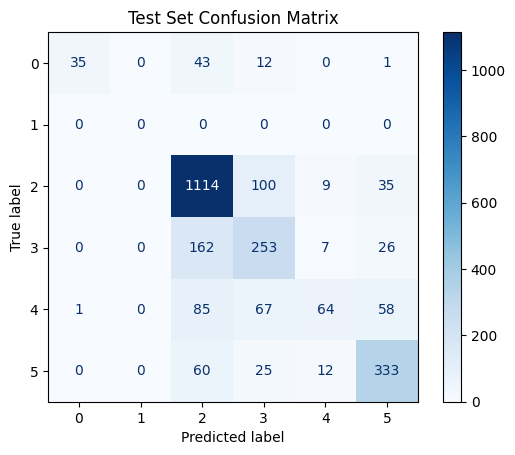


Per-Class Accuracy:
Typhoon Grade 0: 38.46% (35/91 correct)
Typhoon Grade 1: nan% (0/0 correct)
Typhoon Grade 2: 88.55% (1114/1258 correct)
Typhoon Grade 3: 56.47% (253/448 correct)
Typhoon Grade 4: 23.27% (64/275 correct)
Typhoon Grade 5: 77.44% (333/430 correct)
Overall Accuracy: 71.90%


/tmp/ipykernel_489912/3646982790.py:33: RuntimeWarning: invalid value encountered in divide
  per_class_acc = cm.diagonal() / cm.sum(axis=1)


In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ================================================================
# Evaluate on Test Set
# ================================================================
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for xb, yb in tqdm(test_dl, desc="Testing"):
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred_labels = preds.argmax(1).cpu().numpy()
        y_pred.extend(pred_labels)
        y_true.extend(yb.cpu().numpy())

# ------------------------------------------------
# Confusion Matrix
# ------------------------------------------------
num_classes = 6
cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
disp.plot(cmap="Blues", values_format="d")
plt.title("Test Set Confusion Matrix")
plt.show()

# ------------------------------------------------
# Per-Class Accuracy
# ------------------------------------------------
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
print("=" * 40)
for i, acc in enumerate(per_class_acc):
    print(f"Typhoon Grade {i}: {acc * 100:.2f}% ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]} correct)")
print("=" * 40)

overall_acc = np.sum(cm.diagonal()) / np.sum(cm)
print(f"Overall Accuracy: {overall_acc * 100:.2f}%")

Generating predictions for visualization...


Visualizing Samples: 100%|█████████████████████| 25/25 [00:00<00:00, 163.30it/s]


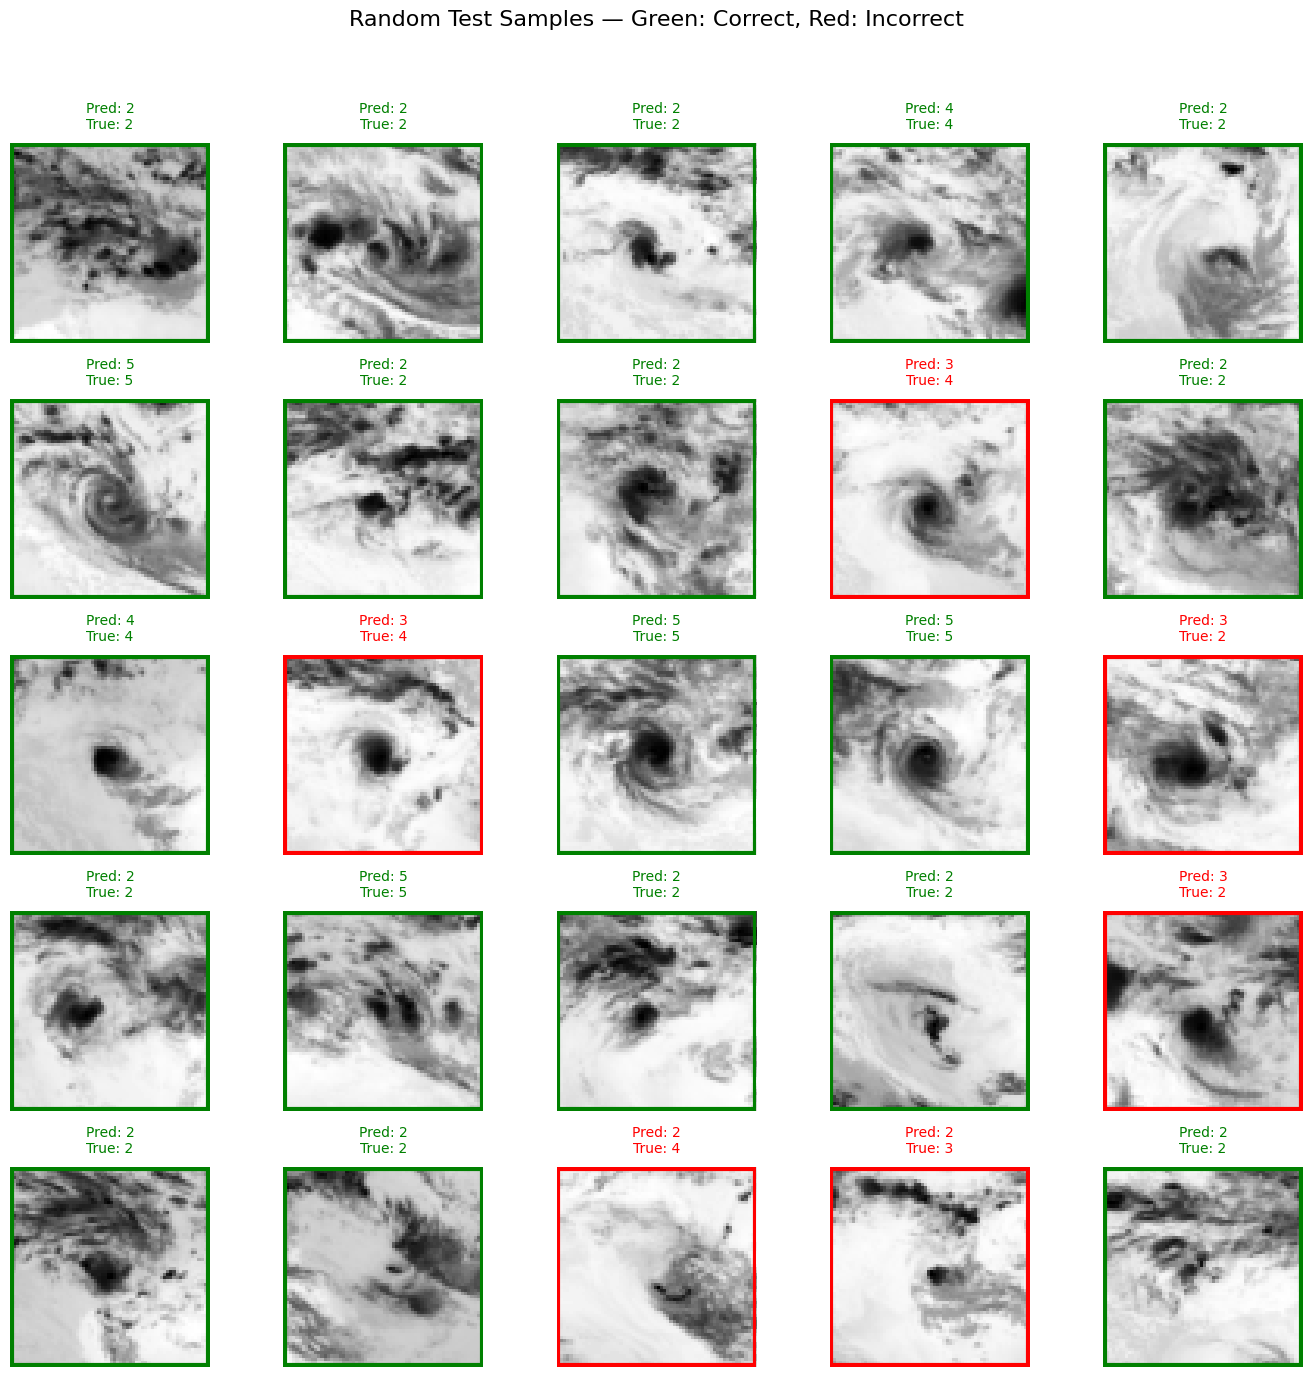

In [12]:
import random
import matplotlib.patches as patches
from tqdm import tqdm

# ================================================================
# Visualize Random Test Predictions (5x5 Grid)
# ================================================================
model.eval()

sample_images = []
sample_preds = []
sample_labels = []

test_samples = list(test_dl)
indices = random.sample(range(len(test_samples)), 25)

print("Generating predictions for visualization...")
with torch.no_grad():
    for i in tqdm(indices, desc="Visualizing Samples"):
        xb, yb = test_samples[i]
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        pred = preds.argmax(1).cpu().numpy()
        label = yb.cpu().numpy()
        sample_images.append(xb.cpu())
        sample_preds.append(pred)
        sample_labels.append(label)

# ------------------------------------------------
# Plot 25 random predictions in 5x5 grid
# ------------------------------------------------
fig, axes = plt.subplots(5, 5, figsize=(14, 14))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx >= len(sample_images):
        ax.axis('off')
        continue

    img_seq = sample_images[idx]             # shape [batch, seq_len, 1, H, W]
    first_frame = img_seq[0, 0, 0].numpy()   # first sample, first timestep, grayscale

    pred_label = sample_preds[idx][0]
    true_label = sample_labels[idx][0]
    correct = pred_label == true_label
    color = "green" if correct else "red"

    ax.imshow(first_frame, cmap="gray")
    ax.set_title(
        f"Pred: {pred_label}\nTrue: {true_label}",
        fontsize=10, color=color, pad=10
    )
    ax.axis("off")

    rect = patches.Rectangle(
        (0, 0),
        first_frame.shape[1] - 1,
        first_frame.shape[0] - 1,
        linewidth=3,
        edgecolor=color,
        facecolor="none"
    )
    ax.add_patch(rect)

plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle("Random Test Samples — Green: Correct, Red: Incorrect", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()